In [4]:
import os
os.chdir('/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification')

In [12]:
import torch
import matplotlib.pyplot as plt

import numpy as np
import rasterio
from src.CNN.CNN_Model import CropTypeClassifier
from shapely.geometry import Point, Polygon
import h5py



In [19]:
label_map = {
    1: "Garlic", 2: "Winter_Oat", 3: "Spring_Oat", 4: "Winter_Durum_Wheat", 5: "Spring_Durum_Wheat",
    6: "Meadow", 7: "Buffer_Strip", 8: "Winter_Wheat", 9: "Beet", 10: "Spring_Wheat",
    11: "Carrot", 12: "Cucumber_Gherkin", 13: "Buckwheat", 14: "Sorghum", 15: "Winter_Rye",
    16: "Fodder", 17: "Rapeseed", 18: "Spelt", 19: "Spinach", 20: "Annual_Vegetable_Fruit",
    21: "Perennial_Vegetable_Fruit", 23: "Hops", 24: "Lavender_Lavandin", 25: "Lettuce_Batavia_Oak_Leaf",
    26: "Grain_Lentil", 27: "Spring_Oil_Flax", 28: "Alfalfa", 29: "Forage_Legume_Cereal_Oilseed_Mix",
    30: "Maize", 31: "Forage_Legume_Mix", 32: "Melon", 33: "Early_Proteaginous_Cereal_Mix",
    34: "Onion_Shallot", 35: "Olive", 36: "Barley", 37: "Chickpea", 38: "Winter_Pea",
    39: "Pumpkin_Red_Kuri", 40: "Early_Spring_Pea", 41: "Potato", 42: "Williams_Pear",
    43: "Vineyard", 44: "Sainfoin", 45: "Soybean", 46: "Clover", 47: "Sunflower",
    48: "Winter_Triticale", 49: "Orchard", 0: "Not a field crops", 22: "Other"
}


In [17]:

model_path='checkpoints/best_model_cnn.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(model_path, device):
    # Instancier ton modèle (adapte le constructeur à ta classe)
    model = CropTypeClassifier(num_classes=51,kernel_size=5)  
    # Charger les poids
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Envoyer le modèle sur le device (CPU ou GPU)
    model.to(device)
    
    return model

model = load_model(model_path, device)

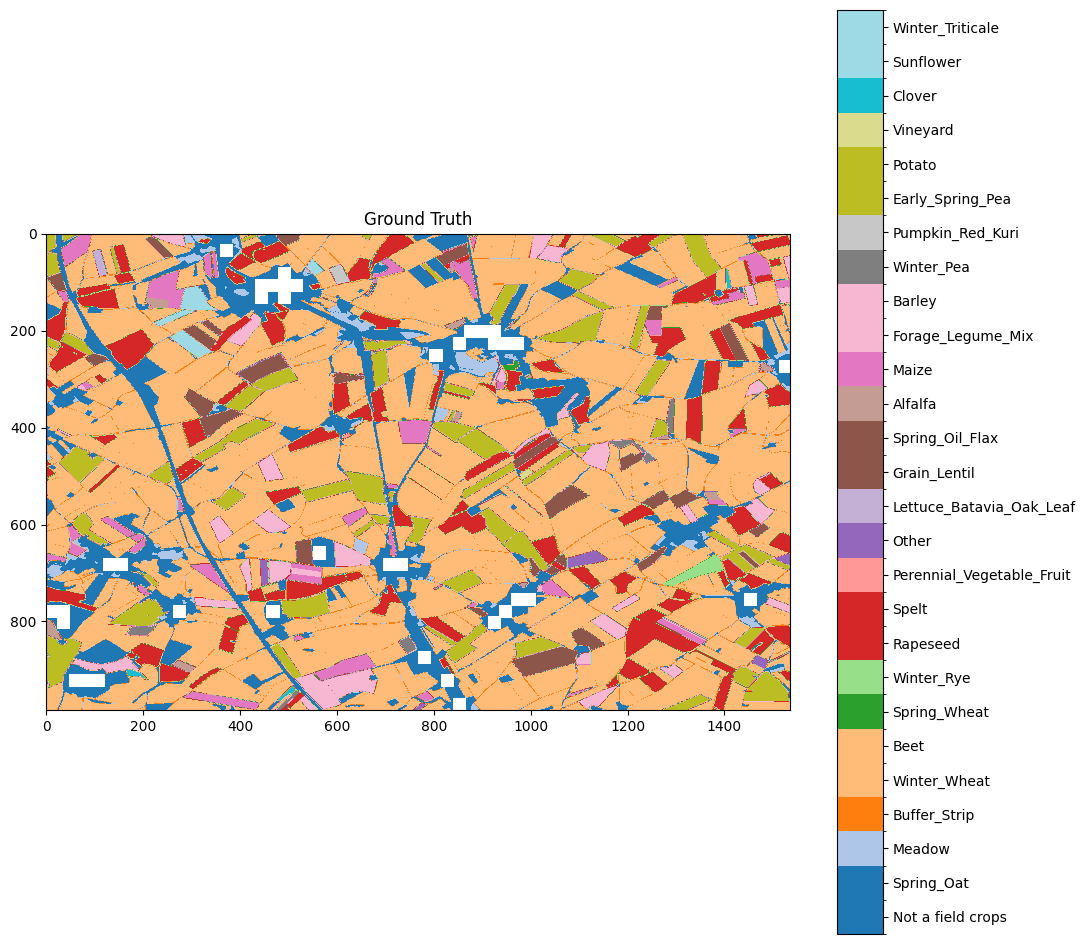

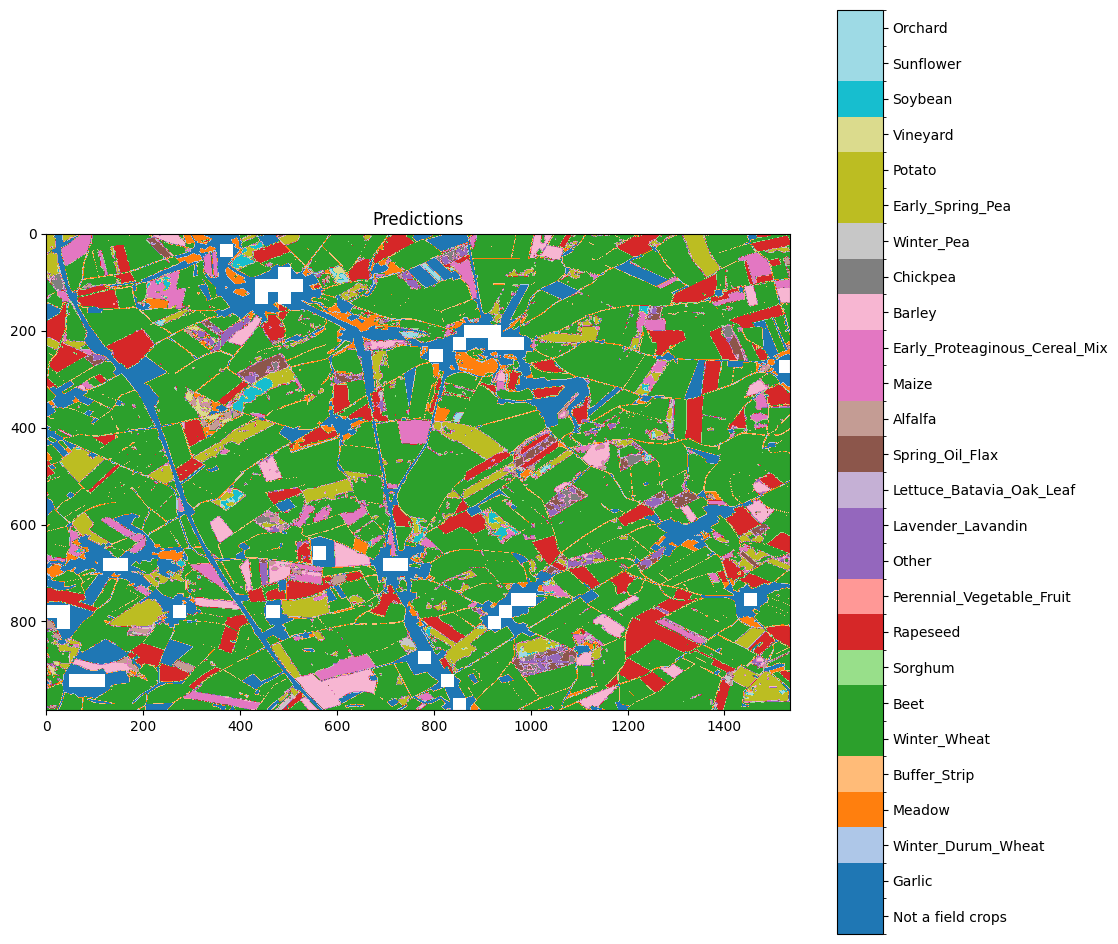

In [ ]:
import torch
import h5py
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

# Charger les données HDF5
target_zone = "zone1"

with h5py.File("manual_jobs/dataset_test.h5", "r") as f:
    X = torch.tensor(f["data"][:])               # shape [N, C, T, H, W]
    Y = torch.tensor(f["labels"][:]).long()      # shape [N, H, W]
    zones = f["zones"][:]                         # bytes ou string
    coords = f["coords"][:]                       # ex: [[lon, lat], ...]

# Convertir zones en str si nécessaire
zones = [z.decode('utf-8') if isinstance(z, bytes) else str(z) for z in zones]

# Filtrer indices correspondant à target_zone
selected_indices = [i for i, z in enumerate(zones) if z == target_zone]

X = X[selected_indices]
Y = Y[selected_indices]
coords = coords[selected_indices]   # Filtrer aussi les coordonnées

# Création d'un dataset simple si besoin (exemple)
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()

pred = []
gt = []
filtered_coords = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        output = model(x)  # [B=1, num_classes, H, W]
        pred_patch = output.argmax(dim=1).squeeze(0).cpu().numpy()
        gt_patch = y.squeeze(0).cpu().numpy()
        
        pred.append(pred_patch)
        gt.append(gt_patch)
        filtered_coords.append(coords[i])  # Récupérer les coordonnées filtrées


# Fonction pour créer la mosaïque spatiale
def create_spatial_mosaic_from_geo_coords(patches, geo_coords, patch_size, transform):
    pixel_coords = [rasterio.transform.rowcol(transform, lon, lat) for lon, lat in geo_coords]
    rows = [r for r, c in pixel_coords]
    cols = [c for r, c in pixel_coords]

    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)

    height = max_row - min_row + patch_size[0]
    width = max_col - min_col + patch_size[1]

    mosaic = np.full((height, width), -1, dtype=patches[0].dtype)

    for patch, (row, col) in zip(patches, pixel_coords):
        row_offset = row - min_row
        col_offset = col - min_col
        mosaic[row_offset:row_offset+patch_size[0], col_offset:col_offset+patch_size[1]] = patch

    return mosaic

# Charger la transformée affine (exemple)
with rasterio.open('/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/data/Tif/zone1/labels_raster_masked.tif') as src:
    transform = src.transform

patch_size = Y.shape[1:]  # H, W des patches

mosaic_preds = create_spatial_mosaic_from_geo_coords(pred, filtered_coords, patch_size, transform)
mosaic_gt = create_spatial_mosaic_from_geo_coords(gt, filtered_coords, patch_size, transform)

# Masquer les zones non couvertes (-1)
masked_mosaic_gt = np.ma.masked_where(mosaic_gt == -1, mosaic_gt)
masked_mosaic_preds = np.ma.masked_where(mosaic_preds == -1, mosaic_preds)



In [ ]:
label_map = {
    1: "Garlic", 2: "Winter_Oat", 3: "Spring_Oat", 4: "Winter_Durum_Wheat", 5: "Spring_Durum_Wheat",
    6: "Meadow", 7: "Buffer_Strip", 8: "Winter_Wheat", 9: "Beet", 10: "Spring_Wheat",
    11: "Carrot", 12: "Cucumber_Gherkin", 13: "Buckwheat", 14: "Sorghum", 15: "Winter_Rye",
    16: "Fodder", 17: "Rapeseed", 18: "Spelt", 19: "Spinach", 20: "Annual_Vegetable_Fruit",
    21: "Perennial_Vegetable_Fruit", 23: "Hops", 24: "Lavender_Lavandin", 25: "Lettuce_Batavia_Oak_Leaf",
    26: "Grain_Lentil", 27: "Spring_Oil_Flax", 28: "Alfalfa", 29: "Forage_Legume_Cereal_Oilseed_Mix",
    30: "Maize", 31: "Forage_Legume_Mix", 32: "Melon", 33: "Early_Proteaginous_Cereal_Mix",
    34: "Onion_Shallot", 35: "Olive", 36: "Barley", 37: "Chickpea", 38: "Winter_Pea",
    39: "Pumpkin_Red_Kuri", 40: "Early_Spring_Pea", 41: "Potato", 42: "Williams_Pear",
    43: "Vineyard", 44: "Sainfoin", 45: "Soybean", 46: "Clover", 47: "Sunflower",
    48: "Winter_Triticale", 49: "Orchard", 0: "Not a field crops", 22: "Other"
}

In [47]:
def plot_with_label_colorbar(mosaic, title,cmap,norm, labels_text,n):
    # classes uniques présentes (exclure -1)
    unique_classes = np.unique(mosaic.compressed() if np.ma.isMaskedArray(mosaic) else mosaic)
    unique_classes = unique_classes[unique_classes != -1]

    plt.figure(figsize=(12, 12))
    plt.title(title)
    im = plt.imshow(mosaic, cmap=cmap, norm=norm)

    # Colorbar ticks uniquement sur les classes présentes
    cbar = plt.colorbar(im, ticks=range(n))

    # Afficher seulement les labels des classes présentes
    cbar.ax.set_yticklabels([labels_text[i] for i in unique_classes])
    plt.show()

In [64]:
H, W = masked_mosaic_gt.shape[:2]
zoom_factor = 2

zoom_h = H // zoom_factor
zoom_w = W // zoom_factor

# Exemple : zoom sur le coin supérieur droit
zoomed_gt = masked_mosaic_gt[0:zoom_h, W - zoom_w:W]
zoomed_preds = masked_mosaic_preds[0:zoom_h, W - zoom_w:W]

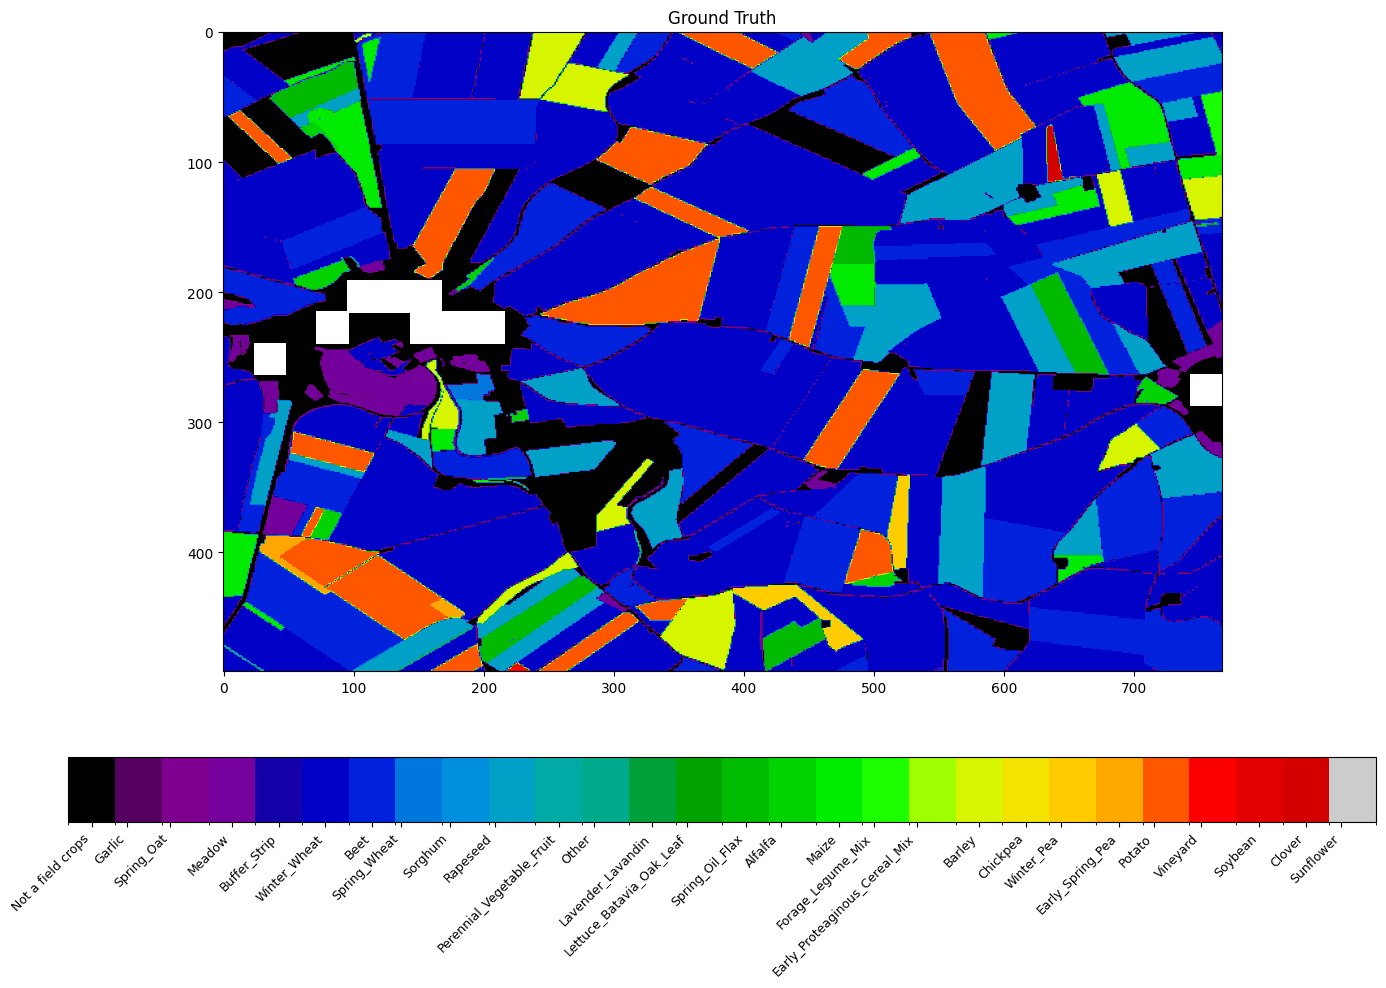

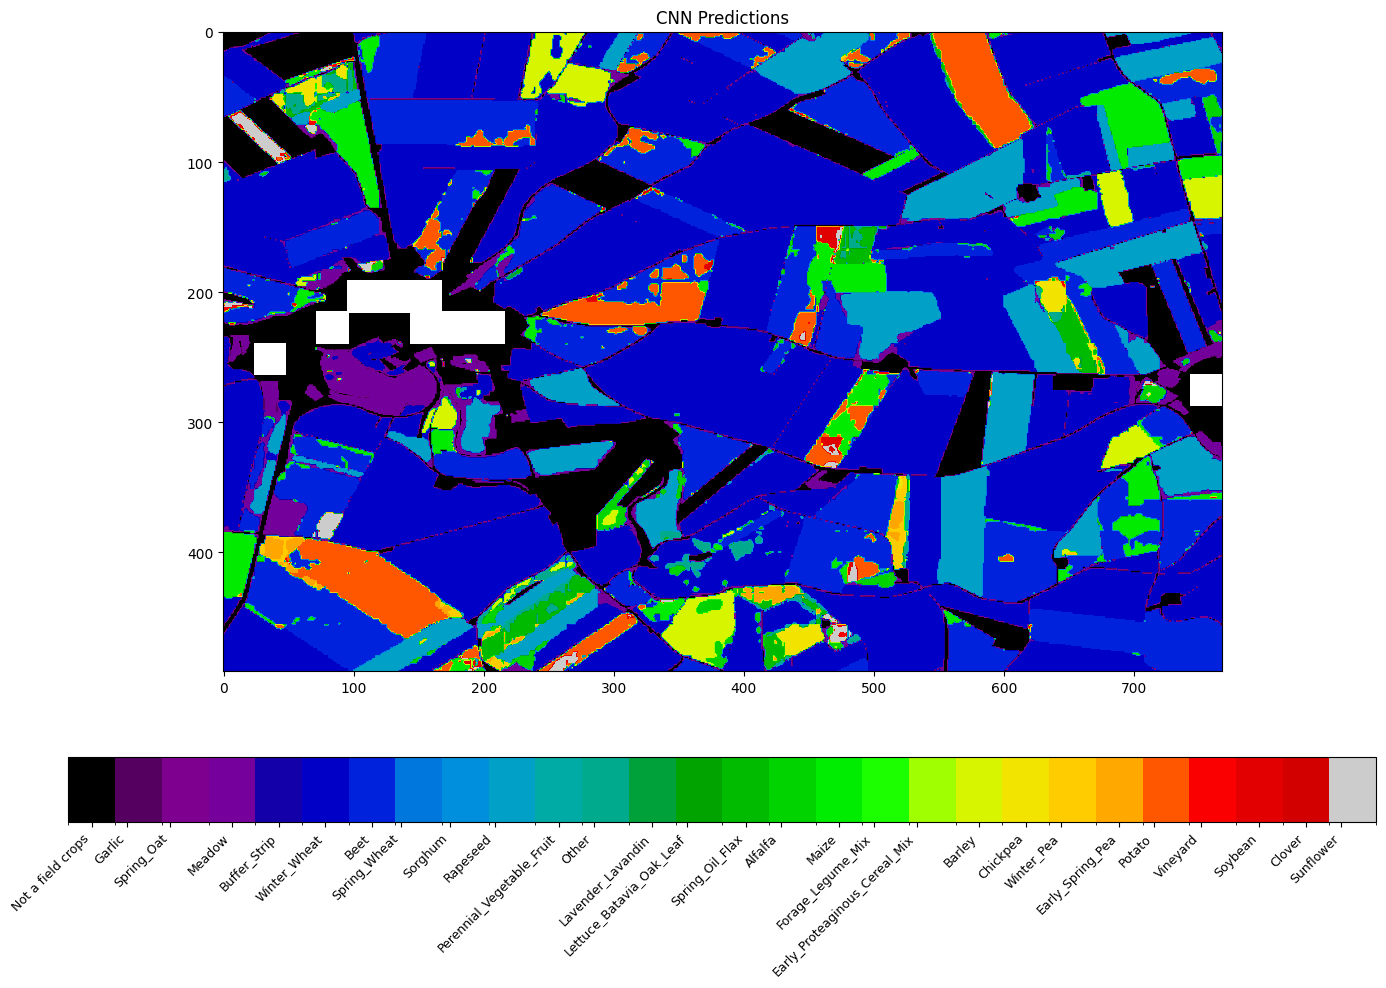

In [67]:
# Étape 1 — Extraire les classes réellement présentes dans chaque mosaïque
def get_present_classes(mosaic):
    unique = np.unique(mosaic.compressed() if np.ma.isMaskedArray(mosaic) else mosaic)
    return unique[unique != -1]

classes_gt = get_present_classes(zoomed_gt)
classes_pred = get_present_classes(zoomed_preds)

# Union des classes pour s'assurer que colormap couvre les deux
all_present_classes = np.unique(np.concatenate([classes_gt, classes_pred]))

# Étape 2 — Créer un cmap spécifique aux classes présentes
cmap = plt.get_cmap('nipy_spectral', len(all_present_classes))
norm = mcolors.BoundaryNorm(boundaries=np.array(all_present_classes) - 0.5, ncolors=len(all_present_classes))

# Étape 3 — Mapping d'ID à label (pour la colorbar)
labels_text = [label_map.get(i, f"Class {i}") for i in all_present_classes]


def plot_with_label_colorbar(mosaic, title, cmap, norm, class_ids, labels_text):
    plt.figure(figsize=(14, 10))
    plt.title(title)
    im = plt.imshow(mosaic, cmap=cmap, norm=norm)

    # Colorbar horizontale en bas
    cbar = plt.colorbar(im, ticks=class_ids, orientation='horizontal', pad=0.1)
    cbar.ax.set_xticklabels(labels_text, rotation=45, ha='right', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_with_label_colorbar(zoomed_gt, "Ground Truth", cmap, norm, all_present_classes, labels_text)
plot_with_label_colorbar(zoomed_preds, "CNN Predictions", cmap, norm, all_present_classes, labels_text)
